In [1]:
import numpy as np
import pandas as pd
from random import shuffle
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torchvision
from torch.utils.data import DataLoader, Dataset, random_split, ConcatDataset
from torchvision import transforms, datasets, models
from train import train_model, train_loss, train_accuracy, val_loss, val_accuracy
from torchsummary import summary
import time
import copy
import seaborn as sns
sns.set(font_scale=1.4)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

batch_size = 32


In [7]:
def norm(dataset):
    output = []
    for sample in tqdm(dataset):
        newimg = []
        img = sample[0]
        label = sample[1]
        for s in img:
            s = s[0]
            s /= torch.max(s)
            s = torch.stack([s, s, s], 0)
            newimg.append(s)
        output.append((newimg, label))
    return output

dataset = torch.load('../../datasets/64skulldataset.pt')
dataset = norm(dataset)

extraAD1 = torch.load('../../datasets/GAN_SS/64ADgan1SS.pt')
extraAD2 = torch.load('../../datasets/GAN_SS/64ADgan2SS.pt')
extraAD3 = torch.load('../../datasets/GAN_SS/64ADgan3SS.pt')

extraNC1 = torch.load('../../datasets/GAN_SS/64NCgan1SS.pt')
extraNC2 = torch.load('../../datasets/GAN_SS/64NCgan2SS.pt')
extraNC3 = torch.load('../../datasets/GAN_SS/64NCgan3SS.pt')

extraAD = [([extraAD1[j][0], extraAD2[j][0], extraAD3[j][0]], extraAD1[j][1]) 
              for j in tqdm(range(len(extraAD1))) ]
extraNC = [([extraNC1[j][0], extraNC2[j][0], extraNC3[j][0]], extraNC1[j][1]) 
              for j in tqdm(range(len(extraNC1))) ]

dataset = torch.utils.data.ConcatDataset((dataset, extraNC, extraAD))

lengths = [

    int(len(dataset) * 0.8),
    int(len(dataset) * 0.1),
    int(len(dataset) * 0.1) + 1
]


trainset, valset, testset = random_split(dataset, lengths)


image_datasets = {'train': trainset, 'val': valset, 'test': testset}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}  

In [3]:
class MultiCNN(nn.Module):
    def __init__(self):
        super(MultiCNN, self).__init__()
        self.fc1 = nn.Linear(6144, 256)
        self.fc2 = nn.Linear(256, 2)
        self.fc3 = nn.Linear(10, 2)
        resnet = models.resnet50(pretrained=True).to(device) 
        self.new_resnet1 = nn.Sequential(*list(resnet.children())[:-1])
        self.new_resnet2 = nn.Sequential(*list(resnet.children())[:-1])
        self.new_resnet3 = nn.Sequential(*list(resnet.children())[:-1])
        self.drop = nn.Dropout(p=0.5)
        
    def forward(self, x_slices):

        x1 = x_slices[0]
        x1 = self.new_resnet1(x1)
        x1 = x1.view(-1, 2048)

        x2 = x_slices[1]
        x2 = self.new_resnet2(x2)
        x2 = x2.view(-1, 2048)

        x3 = x_slices[2]
        x3 = self.new_resnet3(x3)
        x3 = x3.view(-1, 2048)

        out = torch.cat((x1, x2, x3), dim=-1)
        out = F.relu(self.drop(self.fc1(out)))
        out = F.relu(self.fc2(out))

        return out

Epoch 0/49
----------------------------------------------------------------------------------------------------



train Loss: 0.4603 Acc: 0.7687



val Loss: 0.2840 Acc: 0.8729
Epoch 1/49
----------------------------------------------------------------------------------------------------



train Loss: 0.2525 Acc: 0.8936



val Loss: 0.2919 Acc: 0.9025
Epoch 2/49
----------------------------------------------------------------------------------------------------



train Loss: 0.1901 Acc: 0.9275



val Loss: 0.3723 Acc: 0.8941
Epoch 3/49
----------------------------------------------------------------------------------------------------



train Loss: 0.1205 Acc: 0.9693



val Loss: 0.3986 Acc: 0.9280
Epoch 4/49
----------------------------------------------------------------------------------------------------



train Loss: 0.1271 Acc: 0.9629



val Loss: 0.4561 Acc: 0.9025
Epoch 5/49
----------------------------------------------------------------------------------------------------



train Loss: 0.0799 Acc: 0.9730



val Loss: 0.4643 Acc: 0.9195
Epoch 6/49
----------------------------------------------------------------------------------------------------



train Loss: 0.0911 Acc: 0.9836



val Loss: 0.2952 Acc: 0.9068
Epoch 7/49
----------------------------------------------------------------------------------------------------



train Loss: 0.0317 Acc: 0.9899



val Loss: 0.3399 Acc: 0.9364
Epoch 8/49
----------------------------------------------------------------------------------------------------



train Loss: 0.0585 Acc: 0.9947



val Loss: 0.2449 Acc: 0.9237
Epoch 9/49
----------------------------------------------------------------------------------------------------



train Loss: 0.0263 Acc: 0.9968



val Loss: 0.3885 Acc: 0.9322
Epoch 10/49
----------------------------------------------------------------------------------------------------



train Loss: 0.0679 Acc: 0.9989



val Loss: 0.2865 Acc: 0.9153
Epoch 11/49
----------------------------------------------------------------------------------------------------



train Loss: 0.0408 Acc: 0.9995



val Loss: 0.4571 Acc: 0.9280
Epoch 12/49
----------------------------------------------------------------------------------------------------



train Loss: 0.0348 Acc: 0.9995



val Loss: 0.3297 Acc: 0.9364
Epoch 13/49
----------------------------------------------------------------------------------------------------



train Loss: 0.0153 Acc: 1.0000



val Loss: 0.4925 Acc: 0.9407
Epoch 14/49
----------------------------------------------------------------------------------------------------



train Loss: 0.0506 Acc: 0.9989



val Loss: 0.4350 Acc: 0.9449
Epoch 15/49
----------------------------------------------------------------------------------------------------



train Loss: 0.0230 Acc: 0.9995



val Loss: 0.3351 Acc: 0.9492
Epoch 16/49
----------------------------------------------------------------------------------------------------



train Loss: 0.0039 Acc: 1.0000



val Loss: 0.5343 Acc: 0.9068
Epoch 17/49
----------------------------------------------------------------------------------------------------



train Loss: 0.0596 Acc: 0.9995



val Loss: 0.5166 Acc: 0.9110
Epoch 18/49
----------------------------------------------------------------------------------------------------



train Loss: 0.0177 Acc: 0.9989



val Loss: 0.4357 Acc: 0.9237
Epoch 19/49
----------------------------------------------------------------------------------------------------



train Loss: 0.0044 Acc: 1.0000



val Loss: 0.2818 Acc: 0.9364
Epoch 20/49
----------------------------------------------------------------------------------------------------



train Loss: 0.0245 Acc: 0.9989



val Loss: 0.3536 Acc: 0.9492
Epoch 21/49
----------------------------------------------------------------------------------------------------



train Loss: 0.0169 Acc: 0.9995



val Loss: 0.3830 Acc: 0.9364
Epoch 22/49
----------------------------------------------------------------------------------------------------



train Loss: 0.0088 Acc: 1.0000



val Loss: 0.3516 Acc: 0.9407
Epoch 23/49
----------------------------------------------------------------------------------------------------



train Loss: 0.0161 Acc: 0.9995



val Loss: 0.6830 Acc: 0.9068
Epoch 24/49
----------------------------------------------------------------------------------------------------



train Loss: 0.0304 Acc: 0.9984



val Loss: 0.3596 Acc: 0.9364
Epoch 25/49
----------------------------------------------------------------------------------------------------



train Loss: 0.0073 Acc: 1.0000



val Loss: 0.3152 Acc: 0.9364
Epoch 26/49
----------------------------------------------------------------------------------------------------



train Loss: 0.0053 Acc: 0.9995



val Loss: 0.3297 Acc: 0.9407
Epoch 27/49
----------------------------------------------------------------------------------------------------



train Loss: 0.1028 Acc: 0.9984



val Loss: 0.3580 Acc: 0.9449
Epoch 28/49
----------------------------------------------------------------------------------------------------



train Loss: 0.0129 Acc: 1.0000



val Loss: 0.3220 Acc: 0.9364
Epoch 29/49
----------------------------------------------------------------------------------------------------



train Loss: 0.0056 Acc: 1.0000



val Loss: 0.8197 Acc: 0.8686
Epoch 30/49
----------------------------------------------------------------------------------------------------



train Loss: 0.0053 Acc: 1.0000



val Loss: 0.4574 Acc: 0.9492
Epoch 31/49
----------------------------------------------------------------------------------------------------



train Loss: 0.0574 Acc: 0.9989



val Loss: 0.2673 Acc: 0.9322
Epoch 32/49
----------------------------------------------------------------------------------------------------



train Loss: 0.0576 Acc: 0.9995



val Loss: 0.2938 Acc: 0.9322
Epoch 33/49
----------------------------------------------------------------------------------------------------



train Loss: 0.0369 Acc: 0.9984



val Loss: 0.4363 Acc: 0.9237
Epoch 34/49
----------------------------------------------------------------------------------------------------



train Loss: 0.0108 Acc: 0.9989



val Loss: 0.2850 Acc: 0.9449
Epoch 35/49
----------------------------------------------------------------------------------------------------



train Loss: 0.0071 Acc: 1.0000



val Loss: 0.2998 Acc: 0.9407
Epoch 36/49
----------------------------------------------------------------------------------------------------



train Loss: 0.0083 Acc: 0.9995



val Loss: 0.3118 Acc: 0.9280
Epoch 37/49
----------------------------------------------------------------------------------------------------



train Loss: 0.0071 Acc: 1.0000



val Loss: 0.3033 Acc: 0.9492
Epoch 38/49
----------------------------------------------------------------------------------------------------



train Loss: 0.0378 Acc: 0.9989



val Loss: 0.2360 Acc: 0.9322
Epoch 39/49
----------------------------------------------------------------------------------------------------



train Loss: 0.0502 Acc: 0.9974



val Loss: 0.3773 Acc: 0.9407
Epoch 40/49
----------------------------------------------------------------------------------------------------



train Loss: 0.0134 Acc: 1.0000



val Loss: 0.4071 Acc: 0.9364
Epoch 41/49
----------------------------------------------------------------------------------------------------



train Loss: 0.0117 Acc: 0.9989



val Loss: 0.5917 Acc: 0.8983
Epoch 42/49
----------------------------------------------------------------------------------------------------



train Loss: 0.0046 Acc: 1.0000



val Loss: 0.4505 Acc: 0.9449
Epoch 43/49
----------------------------------------------------------------------------------------------------



train Loss: 0.0150 Acc: 0.9989



val Loss: 0.5599 Acc: 0.9153
Epoch 44/49
----------------------------------------------------------------------------------------------------



train Loss: 0.0158 Acc: 0.9989



val Loss: 0.4039 Acc: 0.9280
Epoch 45/49
----------------------------------------------------------------------------------------------------



train Loss: 0.0701 Acc: 0.9984



val Loss: 0.4580 Acc: 0.9407
Epoch 46/49
----------------------------------------------------------------------------------------------------



train Loss: 0.0456 Acc: 0.9995



val Loss: 0.8640 Acc: 0.8686
Epoch 47/49
----------------------------------------------------------------------------------------------------



train Loss: 0.0418 Acc: 0.9995



val Loss: 0.3811 Acc: 0.9364
Epoch 48/49
----------------------------------------------------------------------------------------------------



train Loss: 0.0043 Acc: 1.0000



val Loss: 0.3651 Acc: 0.9492
Epoch 49/49
----------------------------------------------------------------------------------------------------



train Loss: 0.0145 Acc: 1.0000



val Loss: 0.3575 Acc: 0.9449
Training complete in 10m 22s
Best val Acc: 0.949153


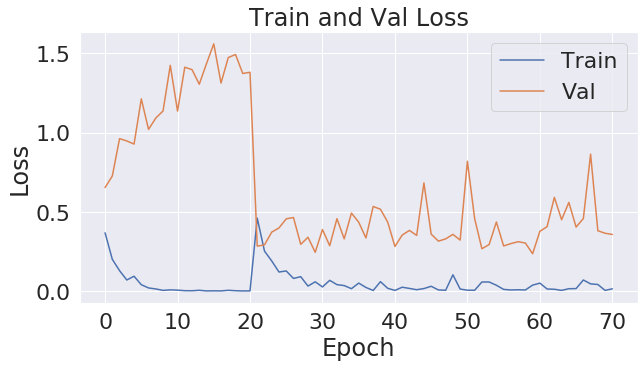

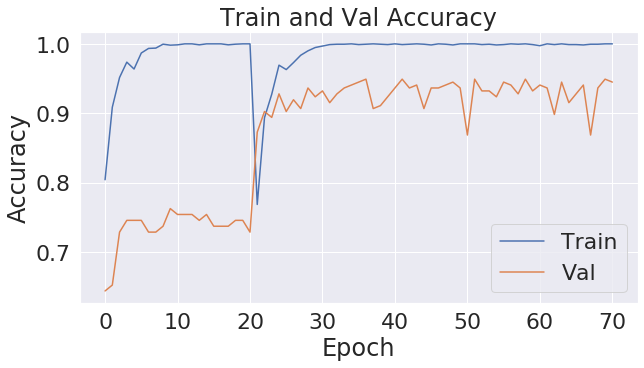

In [8]:
model = MultiCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
model = train_model(model, criterion, optimizer, exp_lr_scheduler, dataloaders, dataset_sizes,
                       num_epochs=50, batch_size = batch_size)

In [5]:
running_loss = 0.0
running_corrects = 0
for inputs, labels in tqdm(dataloaders['test'], total = dataset_sizes['test']//32+1):
    labels = labels.to(device)
    inputs = [i.to(device, dtype = torch.float) for i in inputs]

    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)


    running_loss += loss.item() * 32
    running_corrects += torch.sum(preds == labels.data)
    
print(f"Test Loss: {running_loss / dataset_sizes['test']}\nTest Accuracy: {running_corrects.double() / dataset_sizes['test']}")



Test Loss: 1.0346701966614282
Test Accuracy: 0.7899159663865546


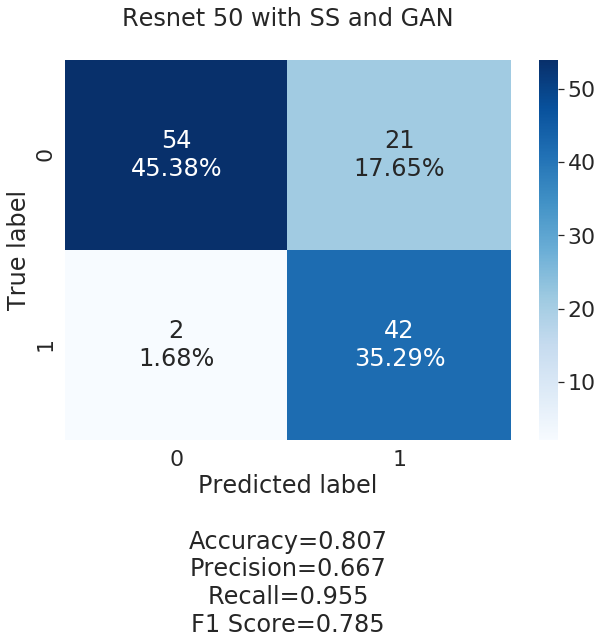

In [6]:
from confusionmatrix import make_confusion_matrix
sns.set(font_scale = 2)
nb_classes = 2
cf = torch.zeros(nb_classes, nb_classes)

with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['test']):
        classes = classes.to(device)
        inputs = [i.to(device, dtype=torch.float) for i in inputs]
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        for t, p in zip(classes.view(-1), preds.view(-1)):
            cf[t.long(), p.long()] += 1

cf = np.array(cf)

group_names = ['bruh','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf.reshape(-1)/cf.sum()]

labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]

make_confusion_matrix(cf, group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize= (10,7),
                          cmap='Blues',
                          title='Resnet 50 with SS and GAN\n')